In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.decomposition import PCA
import scipy.optimize

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")
pwd_mat = os.path.join(os.path.join(path2p, "data/"), "sim_ds_mat")
pwd_h5 = os.path.join(os.path.join(path2p, "data/"), "sim_ds_h5")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_mat
from matlab.matlab_lib import loadmat
from corr_lib import sprMat
from qt_wrapper import gui_fpath

Appended library directory /home/alyosha/work/git/nest-mesoscopic-metric-test/codes/lib


## 0. Loading data

In [2]:
# Read LVM file from command line
pwd = '/mnt/hifo_scratch1/Yaro/data_for_TE/'
data_path = gui_fpath("Select data directory", pwd)
data, behaviour = read_mat(data_path)

# Get parameters
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg/mvg_5/mvg_5_2017_11_15_a
Loaded neuronal data with (nTrials, nTimes, nChannels)= (650, 201, 12)


In [11]:
# print(behaviour['trials'].keys())

# print(behaviour['trials']['decision_time'])

pd.DataFrame(behaviour['trials'])

,auto_reward,decision,decision_time,end_time,id,inhibition,no,puff,report,reward_time,stimulus,stimulus_time,time_stamp
0,NaN,Go,6169.6,8471.9,1,none,1,[],report,6166.6,Texture 1 P100,3142.3,07:54:35.1177
1,NaN,No Go,7501.7,9985.0,2,none,2,[],report,NaN,Texture 3 P1200,3068.3,07:54:50.7213
2,NaN,Go,6081.6,8459.8,3,none,3,[],report,6078.6,Texture 1 P100,3087.3,07:55:07.8360
3,NaN,Go,5944.6,8246.8,4,none,4,[],report,5942.6,Texture 1 P100,3081.3,07:55:23.4206
4,NaN,No Go,7500.7,9984.0,5,none,5,[],report,NaN,Texture 3 P1200,3069.3,07:55:38.7991
5,NaN,Go,5932.6,8236.8,6,none,6,[],report,5929.6,Texture 1 P100,3067.3,07:55:55.9148
6,NaN,Inappropriate Response,6170.7,10385.1,7,none,7,[],report,NaN,Texture 3 P1200,3070.3,07:56:11.2793
7,NaN,Inappropriate Response,5937.6,10156.0,8,none,8,[],report,NaN,Texture 3 P1200,3074.3,07:56:28.7961
8,NaN,Inappropriate Response,5987.6,10203.0,9,none,9,[],report,NaN,Texture 3 P1200,3126.3,07:56:46.0858
9,NaN,Inappropriate Response,5988.6,11208.1,10,none,10,[],report,NaN,Texture 3 P1200,3067.3,07:57:03.4226


# 1. Autoregression

What to include into model:
1. Autoregressive Dynamics
$$\vec{x}(t+1) = A\vec{x}(t)$$
2. Neural noise, to model input from external sources
$$\vec{x}(t+1) = A\vec{x}(t) + \nu, \;\;\;\;\; \nu \sim \mathcal{N}(\vec{\mu}, \Sigma)$$
3. Input and input-coupling
$$ \vec{x}(t+1) = A\vec{x}(t) + B\vec{u}(t) + C \vec{x}(t) \vec{u}(t) + \nu$$
4. Observable convolution
$$
\begin{eqnarray}
  \tau \dot{y} &=& -y + x \\
  \vec{y}(t+1) &\approx& \alpha \vec{x}(t) + (1 - \alpha) \vec{y}(t), \;\;\;\;\; \alpha = \frac{\Delta t}{\tau}
\end{eqnarray}$$

**TODO**:
* See what tools for autoregressors exist
* Read literature on DCM, understand how it works, how it is different from autoregressor
* For observable autoregressor, is it not equivalent to simply deconvolving data and then using basic deconvolved?
   $$x(t) = y(t) + \frac{y(t+1) - y(t)}{\alpha}$$
   * Ask Yaro if he thinks this makes sense
   * Look for most optimal deconvolution tool for this process

In [3]:
def unpack(Aarr):
    return Aarr.reshape(nChannels, nChannels)

def model(Data, A):   # Future time step from prev. one
    return Data.dot(A.T)

# def L(Aarr):
#     Amat = unpack(Aarr)
#     data_guess = model(data, Amat)
#     residue = np.linalg.norm(data[:, 1:, :] - data_guess[:, :-1, :])
#     return residue

d_0 = data[:, :-1, :].transpose(2, 0, 1).reshape(nChannels, (nTimes-1)*nTrials)
d_1 = data[:, 1:, :].transpose(2, 0, 1).reshape(nChannels, (nTimes-1)*nTrials)
len_d = d_0.shape[1]

D1 = np.linalg.norm(d_1)**2
D10  = np.einsum('ij, kj', d_1, d_0)
D00 = np.einsum('kj, lj', d_0, d_0)

def reg(Amat):
    return 5.0*np.sum(np.abs(Amat))

def L2_fast(Aarr):
    Amat = unpack(Aarr)
    B = -2*np.einsum('ij, ij', Amat, D10)
    C = np.einsum('ik,il,kl', Amat, Amat, D00)
    return D1 + B + C + reg(Amat)

In [ ]:
# Example 1:
A0arr = np.random.normal(0, 1, nChannels**2)

bounds = [(0, 10) for i in range(nChannels**2)]
min_obj = scipy.optimize.minimize(L2_fast, A0arr, bounds=bounds, method='SLSQP')

print(min_obj.success)
print(min_obj.message)

A = unpack(min_obj.x)
A[A < 1.0e-10] = 0

# Compute fitness
L2_without_reg = np.sqrt(min_obj.fun - reg(A))
print(L2_without_reg, "compared to", np.linalg.norm(data[:, 1:, :]))

plt.figure(figsize=(10,10))
plt.imshow(unpack(min_obj.x))
plt.colorbar()
plt.show()

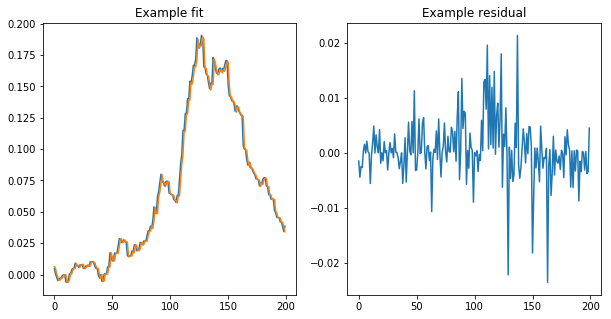

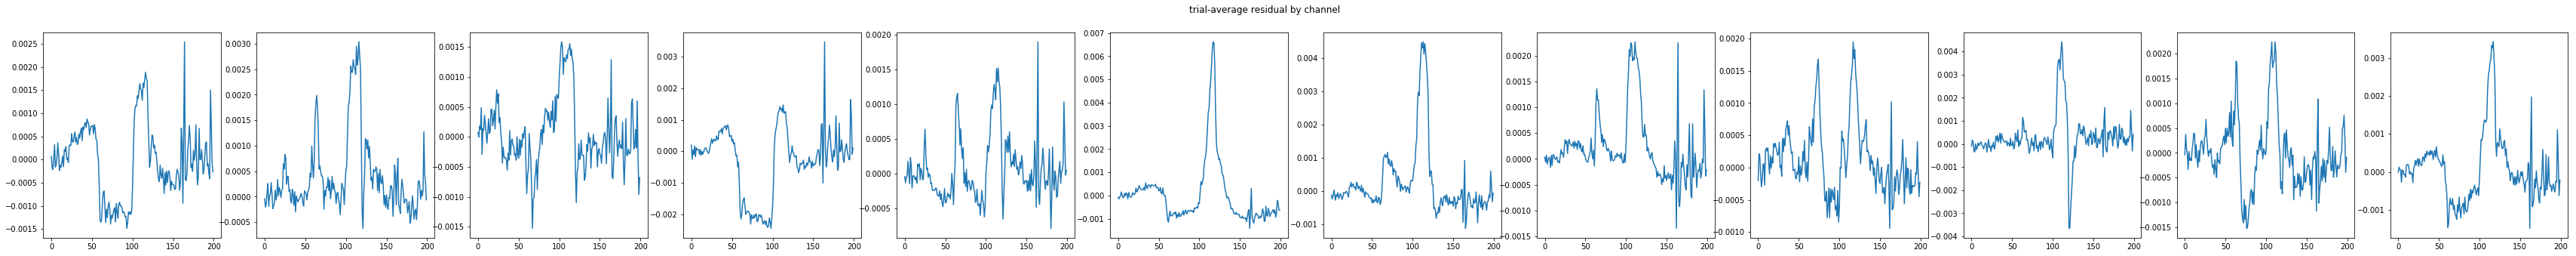

In [13]:
#display(pd.DataFrame(A))

Data_model = model(data[:, :-1, :], A)
Residual = data[:, 1:, :] - Data_model

N_CH = 6
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].set_title("Example fit")
ax[1].set_title("Example residual")
ax[0].plot(data[0, 1:, N_CH])
ax[0].plot(Data_model[0, :, N_CH])
ax[1].plot(Residual[0, :, N_CH])
plt.show()

fig, ax = plt.subplots(ncols=nChannels, figsize=(5*nChannels, 5))
fig.suptitle("trial-average residual by channel")
for i in range(nChannels):
    ax[i].plot(np.average(Residual[:, :, i], axis=0))
plt.show()

In [16]:
data.shape

(885, 201, 12)